# Data Science Project

* Name: Author Name
* Email:


## TABLE OF CONTENTS 


- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

# INTRODUCTION

> Explain the point of your project and what question you are trying to answer with your modeling.



In [1]:
from distutils.util import strtobool
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import ticker
import seaborn as sns
import missingno as msno

sns.set_theme(font_scale=1, style='darkgrid')
sns.set_palette("deep", desat=0.85, color_codes=True)
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
from tools import cleaning, outliers, plotting

# OBTAIN

In [3]:
df = pd.read_csv("data/bank-additional-full.csv", sep=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
df.nunique()

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64

# SCRUB

I rename some features to make them a little easier to interpret. Every variable prefixed with "contact" has to do with the last contact of the current campaign.

In [6]:
df.columns = df.columns.str.replace(".", "_", regex=False)
rename = {"y": "invested",
        "poutcome": "prev_outcome",
        "pdays": "days_since_prev",
        "previous": "prev_contact_count",
        "campaign": "contact_count",
        "month": "contact_month",
        "day_of_week": "contact_weekday",
        "duration": "contact_duration",
        "contact": "contact_type",
        "nr_employed": "n_employed",
        "euribor3m": "euribor_3m"}
df.rename(columns=rename, inplace=True)
del rename
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact_type', 'contact_month', 'contact_weekday', 'contact_duration',
       'contact_count', 'days_since_prev', 'prev_contact_count',
       'prev_outcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx',
       'euribor_3m', 'n_employed', 'invested'],
      dtype='object')

In [7]:
df["days_since_prev"].replace(999, np.NaN, inplace=True)
df.replace(["unknown", "nonexistent"], np.NaN, inplace=True)
cleaning.info(df)

,nan,nan_%,uniq,uniq_%,dup,dup_%
days_since_prev,39673,96.32,26,0.06,12,0.03
prev_outcome,35563,86.34,2,0.00,12,0.03
default,8597,20.87,2,0.00,12,0.03
education,1731,4.20,7,0.02,12,0.03
housing,990,2.40,2,0.00,12,0.03
loan,990,2.40,2,0.00,12,0.03
job,330,0.80,11,0.03,12,0.03
marital,80,0.19,3,0.01,12,0.03
age,0,0.00,78,0.19,12,0.03
n_employed,0,0.00,11,0.03,12,0.03


In [8]:
display(df.loc[df.duplicated()])
df.drop_duplicates(inplace=True)

,age,job,marital,education,default,housing,loan,contact_type,contact_month,contact_weekday,...,contact_count,days_since_prev,prev_contact_count,prev_outcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,n_employed,invested
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,NaN,0,NaN,1.1,93.994,-36.4,4.855,5191.0,no
12261,36,retired,married,NaN,no,no,no,telephone,jul,thu,...,1,NaN,0,NaN,1.4,93.918,-42.7,4.966,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,NaN,0,NaN,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,NaN,0,NaN,1.4,93.918,-42.7,4.962,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,NaN,0,NaN,1.4,93.918,-42.7,4.968,5228.1,no
20216,55,services,married,high.school,NaN,no,no,cellular,aug,mon,...,1,NaN,0,NaN,1.4,93.444,-36.1,4.965,5228.1,no
20534,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,...,1,NaN,0,NaN,1.4,93.444,-36.1,4.966,5228.1,no
25217,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,...,2,NaN,0,NaN,-0.1,93.200,-42.0,4.153,5195.8,no
28477,24,services,single,high.school,no,yes,no,cellular,apr,tue,...,1,NaN,0,NaN,-1.8,93.075,-47.1,1.423,5099.1,no
32516,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,4,NaN,0,NaN,-1.8,92.893,-46.2,1.313,5099.1,no


In [9]:
cleaning.show_uniques(df, cut=20)

job,marital,education,default,housing,loan,contact_type,contact_month,contact_weekday,prev_contact_count,prev_outcome,emp_var_rate,n_employed,invested
housemaid,married,basic.4y,no,no,no,telephone,may,mon,0.0,failure,1.1,5191.0,no
services,single,high.school,yes,yes,yes,cellular,jun,tue,1.0,success,1.4,5228.1,yes
admin.,divorced,basic.6y,,,,,jul,wed,2.0,,-0.1,5195.8,
blue-collar,,basic.9y,,,,,aug,thu,3.0,,-0.2,5176.3,
technician,,professional.course,,,,,oct,fri,4.0,,-1.8,5099.1,
retired,,university.degree,,,,,nov,,5.0,,-2.9,5076.2,
management,,illiterate,,,,,dec,,6.0,,-3.4,5017.5,
unemployed,,,,,,,mar,,7.0,,-3.0,5023.5,
self-employed,,,,,,,apr,,,,-1.7,5008.7,
entrepreneur,,,,,,,sep,,,,-1.1,4991.6,


<AxesSubplot:>

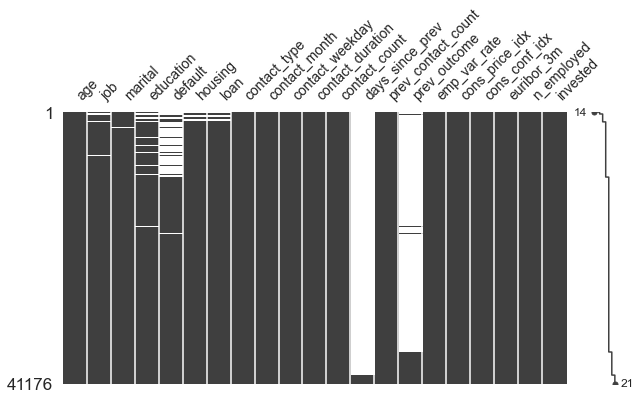

In [10]:
msno.matrix(df, figsize=(10, 5), sort="ascending", fontsize=14)

In [11]:
to_bool = ["default", "housing", "loan", "invested"]

# convert string categories to binary numeric
df[to_bool] = (df.loc[:, to_bool]
                .applymap(strtobool, "ignore")
                .astype(np.float64))

# convert 'invested' to bool because no NaNs
# (NaN converts to False, which I don't want)
df["invested"] = df["invested"].astype(np.bool_)

df[to_bool].head()

,default,housing,loan,invested
0,0.0,0.0,0.0,False
1,NaN,0.0,0.0,False
2,0.0,1.0,0.0,False
3,0.0,0.0,0.0,False
4,0.0,0.0,1.0,False


Looks like "default" only has 3 True values. Let's just get rid of it.

In [12]:
display(cleaning.token_info(df[to_bool]))
df.drop(columns="default", inplace=True)
del to_bool
df.columns

,min_tokens,max_tokens,types
default,3,32577,2
housing,18615,21571,2
loan,6248,33938,2
invested,4639,36537,2


Index(['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact_type',
       'contact_month', 'contact_weekday', 'contact_duration', 'contact_count',
       'days_since_prev', 'prev_contact_count', 'prev_outcome', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'n_employed',
       'invested'],
      dtype='object')

I go ahead and convert "prev_outcome" into two separate boolean features, eliminating ~35k NaNs and avoiding collinearity by implicitly dropping the NaN category. I wouldn't want to impute values for NaNs when they make up the vast majority.

In [13]:
df["prev_success"] = df["prev_outcome"] == "success"
df["prev_failure"] = df["prev_outcome"] == "failure"
df.drop(columns="prev_outcome", inplace=True)
df[["prev_success", "prev_failure"]].head()

,prev_success,prev_failure
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False


In [14]:
cleaning.token_info(df[["prev_success", "prev_failure"]])

,min_tokens,max_tokens,types
prev_success,1373,39803,2
prev_failure,4252,36924,2


Now to interpret the "days_since_prev" a.k.a. "pdays" feature. The guide says:

> number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

Passed by until what? Presumably, until they called back. But what if they never called back? Maybe those who never called back are also chalked up as null values, even though the guide doesn't say that.

Yep, as shown below, there are rows where "days_since_prev" is null and "prev_failure" is True. This must mean that those who never called back are chalked up as 999 days (null) and also as failures.

In [15]:
df.loc[df["prev_failure"], ["days_since_prev", "prev_failure"]].head()

,days_since_prev,prev_failure
24013,NaN,True
24019,NaN,True
24076,NaN,True
24102,NaN,True
24113,NaN,True


One week seems like a natural cutoff point for turning "days_since_prev" into categoricals.

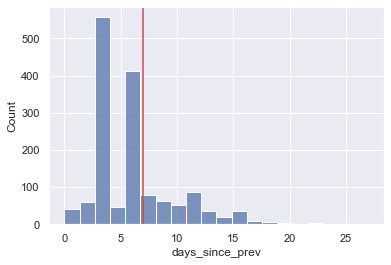

In [16]:
ax = sns.histplot(data=df, x="days_since_prev", bins=20)
ax.axvline(7, c="r")

I create three boolean variables for those who responded in under a week, over a week, or not at all. This effectively drops the NaN category.

I drop "days_since_prev" which is 96% NaNs and no longer necessary.

In [17]:
df["prev_callback_under_1w"] = df["days_since_prev"] <= 7
df["prev_callback_over_1w"] = df["days_since_prev"] > 7
df["prev_callback_never"] = df["days_since_prev"].isna() & df["prev_failure"]
df.drop(columns="days_since_prev", inplace=True)
df.filter(like="prev_callback").tail()

,prev_callback_under_1w,prev_callback_over_1w,prev_callback_never
41183,False,False,False
41184,False,False,False
41185,False,False,False
41186,False,False,False
41187,False,False,True


I convert the binary "contact_type" feature to a boolean feature "contact_cellular". Again, every variable with the "contact" prefix has to do with the last contact of the current campaign.

In [18]:
df["contact_cellular"] = df["contact_type"] == "cellular"
df.drop(columns="contact_type", inplace=True)
df["contact_cellular"].value_counts()

True     26135
False    15041
Name: contact_cellular, dtype: int64

In [19]:
to_cat = ["job", "marital", "education", "contact_month", "contact_weekday"]

# tweak some labels
df["job"] = df["job"].str.replace(".", "", regex=False)
df["job"] = df["job"].str.replace("-", "_", regex=False)
df["education"] = df["education"].str.replace(".", "_", regex=False)

# convert to unordered categoricals
df[to_cat] = df[to_cat].astype("category")



cleaning.show_uniques(df, columns=to_cat)
del to_cat

job,marital,education,contact_month,contact_weekday
housemaid,married,basic_4y,may,mon
services,single,high_school,jun,tue
admin,divorced,basic_6y,jul,wed
blue_collar,,basic_9y,aug,thu
technician,,professional_course,oct,fri
retired,,university_degree,nov,
management,,illiterate,dec,
unemployed,,,mar,
self_employed,,,apr,
entrepreneur,,,sep,


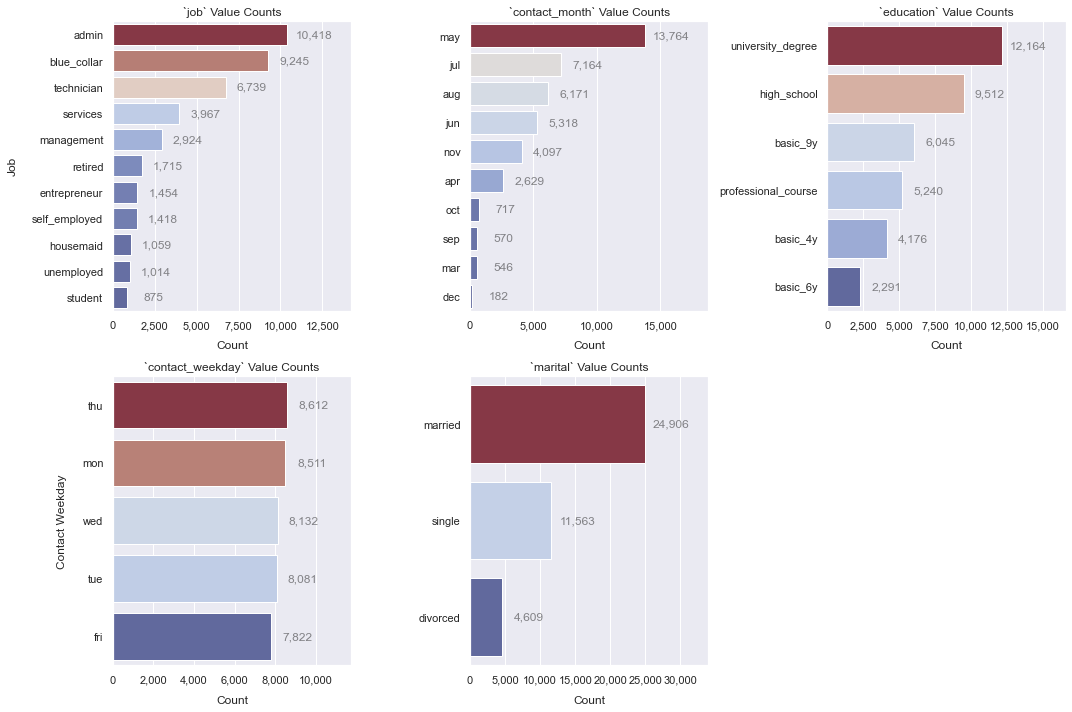

In [35]:
plotting.multi_countplot(df.select_dtypes("category"));

In [21]:
keep = df.education != "illiterate"
df = df.loc[keep].copy()
df["education"] = df["education"].cat.remove_unused_categories()
del keep
cleaning.token_info(df[["education"]])

,min_tokens,max_tokens,types
education,2291,12164,6


In [22]:
# define order
days = ["mon", "tue", "wed", "thu", "fri"]
months = ["mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]

# convert to ordered categories
df["contact_weekday"].cat.reorder_categories(days, ordered=True, inplace=True)
df["contact_month"].cat.reorder_categories(months, ordered=True, inplace=True)

# mop up temp variables
del days, months

display(df["contact_weekday"].cat.categories)
display(df["contact_month"].cat.categories)

Index(['mon', 'tue', 'wed', 'thu', 'fri'], dtype='object')

Index(['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], dtype='object')

# EXPLORE

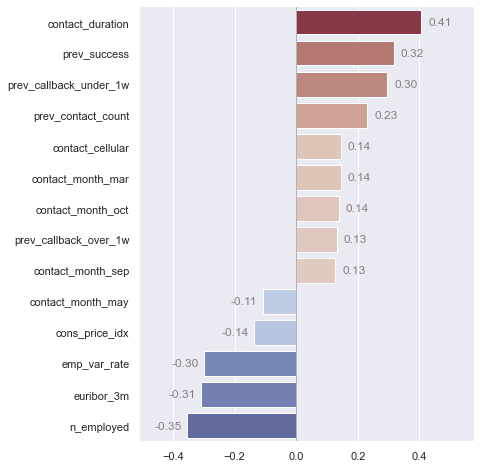

In [23]:
inv_corr = pd.get_dummies(df.drop(columns="invested"))
inv_corr = inv_corr.corrwith(df["invested"])
inv_corr = inv_corr.loc[inv_corr.abs() > .1]
ax = plotting.heated_barplot(inv_corr)
plotting.annot_bars(ax)
del inv_corr, ax

<AxesSubplot:title={'center':'Correlations Between Features'}>

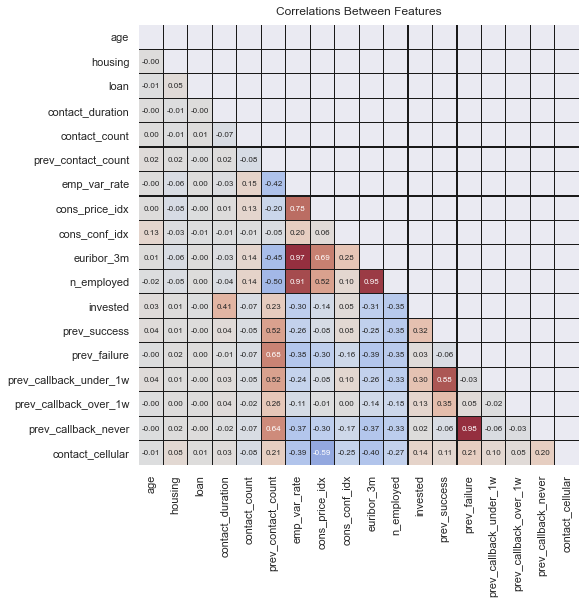

In [24]:
plotting.pair_corr_heatmap(df, scale=.45)

<AxesSubplot:title={'center':'Correlation with Numeric Features'}, xlabel='Numeric Features', ylabel='Categorical Features'>

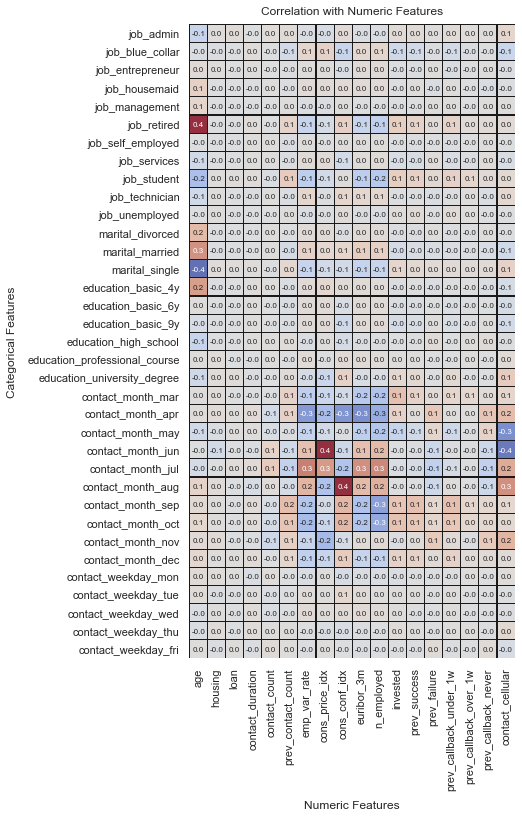

In [25]:
plotting.cat_corr_heatmap(df, df.select_dtypes("category").columns, scale=.333, fmt=".1f")

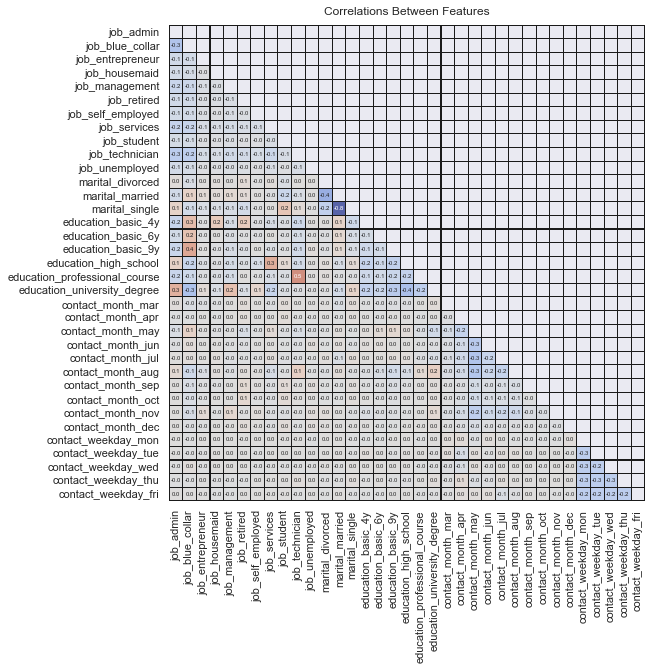

In [26]:
dummies = pd.get_dummies(df.select_dtypes("category"))
plotting.pair_corr_heatmap(dummies,
                        scale=.25, 
                        annot_kws={"fontsize": 6}, 
                        fmt=".1f")
del dummies

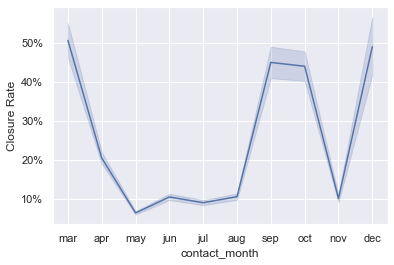

In [27]:
ax = sns.lineplot(data=df, x="contact_month", y="invested")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.set_ylabel("Closure Rate")
del ax

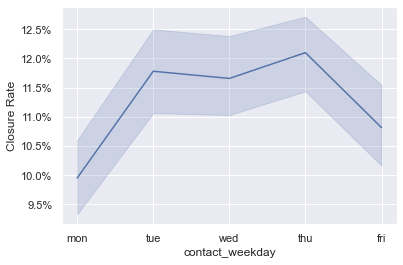

In [28]:
ax = sns.lineplot(data=df, x="contact_weekday", y="invested")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
ax.set_ylabel("Closure Rate")
del ax

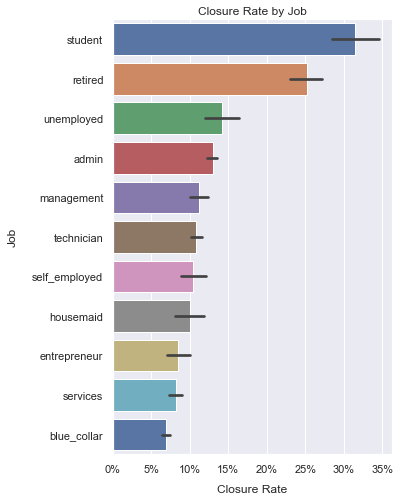

In [29]:
ax = plotting.simple_barplot(df, "job", "invested", sort="desc", orient="h", palette="deep")
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_xlabel("Closure Rate", labelpad=10)
ax.set_title("Closure Rate by Job", pad=5)
del ax

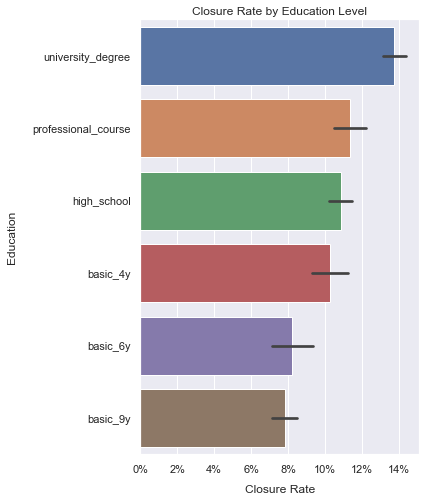

In [37]:
ax = plotting.simple_barplot(df, "education", "invested", sort="desc", orient="h", palette="deep")
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_xlabel("Closure Rate", labelpad=10)
ax.set_title("Closure Rate by Education Level", pad=5)
del ax

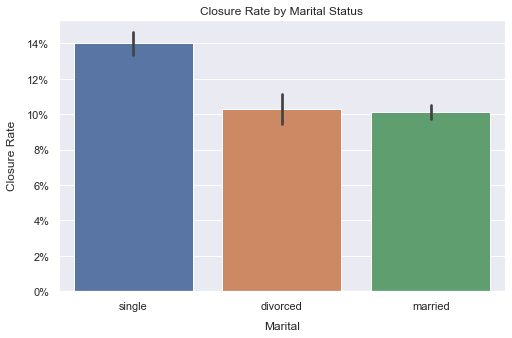

In [31]:
ax = plotting.simple_barplot(df, "marital", "invested", sort="desc", orient="v", palette="deep")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylabel("Closure Rate", labelpad=10)
ax.set_title("Closure Rate by Marital Status", pad=5)
del ax

# MODEL

# iNTERPRET

# CONCLUSIONS & RECOMMENDATIONS

> Summarize your conclusions and bullet-point your list of recommendations, which are based on your modeling results.

# TO DO/FUTURE WORK

- 